# Error Analysis of Track Pattern Recognition Methods

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas
import numpy

import user_test_submission as submission

# Input data

In [2]:
name = "m20_ptmin300_ptmax10000"
data = pandas.read_csv('datasets/'+name+'.csv', index_col=False)

data.head()

,event_id,cluster_id,layer,iphi,x,y
0,200100,1,1,10210,-84.183998,11.749662
1,200100,0,2,28849,-9.194540,-154.727051
2,200100,5,8,7919,922.630937,385.684008
3,200100,3,6,24776,-332.660900,452.968791
4,200100,1,0,4726,-38.754876,4.365727


# Data Preparation

In [3]:
X = data[[u'event_id', u'layer', u'iphi', u'x', u'y']].values
y = data[[u'event_id', u'cluster_id']].values

# Train/Test Split

In [4]:
from sklearn.model_selection import train_test_split

event_ids = numpy.unique(data['event_id'].values)

event_ids_train, event_ids_test = train_test_split(event_ids, 
                                                   test_size=1000, 
                                                   random_state=42)

X_train, y_train = X[data['event_id'].isin(event_ids_train)], y[data['event_id'].isin(event_ids_train)]
X_test, y_test = X[data['event_id'].isin(event_ids_test), 1:], y[data['event_id'].isin(event_ids_test)]

# Track Pattern Recognition

Just put here a script form the leaderboard.

In [5]:
import numpy as np
import math
from sklearn.base import BaseEstimator
from sklearn.cluster import DBSCAN

RLayer=np.array([39,85,155,213,271,405,562,762,1000]) 
Pitch=np.array([0.025,0.025,0.025,0.025,0.025, 0.05, 0.05,0.05,0.05])
MeasError=np.array([0.1,0.1,0.1,0.1,0.1,0.2,0.2,0.2,0.2])
MS=np.array([1+i*0.05 for i in range(len(RLayer))])
PhiSigma = MS*MeasError/RLayer
SharedHitCost=7.5
MaxDPhi=65.
MinHits=3

def RPhi(iLayer, iPhi):
    return iPhi*Pitch[int(iLayer)]/RLayer[int(iLayer)]

def deltaPhi(a, b):
    delta = a - b
    del2pi = a - b - 2*math.pi
    if abs(delta) > abs(del2pi):
        return del2pi
    else:
        return delta

def get_phi(x,y):
    x=np.array(x)
    y=np.array(y)
    return np.arctan2(y,x)

class Clusterer(BaseEstimator):
    def __init__(self, max_dphi=MaxDPhi):
        """
        Track Pattern Recognition based on the connections between two nearest hits from two nearest detector layers.
        Parameters
        ----------
        max_dphi : float
            Minimum cos value between two nearest segments of the track.
        """
        self.max_dphi = max_dphi*PhiSigma

    def fit(self, X, y):
        pass
        
    def predict_single_event(self, X_event):
        #print "predict single event"
        #print X_event[:, 0], X_event[:, 1]
        layers = X_event[:, 0].astype(np.int)
        rphi=np.zeros(len(layers))
        for i in range(len(layers)):
            rphi[i]=RPhi(X_event[i, 0], X_event[i, 1])
        #print "layer", layers, "rphi", rphi
        used=np.zeros(len(layers))
        #usedVec = [[] for i in range(len(layers))]
        labels = -1 * np.ones(len(rphi), dtype='int')
        track_id = 0
        #print len(layers), len(rphi)
        #rphi = get_phi(X_event[:,2], X_event[:,3])
        

        # Start from an unused hit in the first and last three layer:
        # -1,0,-2,1,-3,2
        for iLayer in range(3):
            currLayer=len(RLayer)-iLayer-1
            #print "currLayer ", currLayer
            for first_id in np.arange(0, len(layers))[(layers == currLayer) * (used==0)]:
                #print "start new track with hit ", first_id, " in layer ", currLayer
                #print np.arange(0, len(layers))[layers == 8]
                track = []
                track += [first_id]

                ave_d2phi=0
                nHits=0
                # Go through other detector layers outside in
                for one_layer in reversed(np.unique(layers)[:currLayer]):
                    #print "one_layer", one_layer
                    # Select hits of the layer
                    #hit_ids = np.arange(0, len(layers))[(layers == one_layer) * (used == 0)]
                    hit_ids = np.arange(0, len(layers))[(layers == one_layer)]
                    # Compute distance between hits
                    diff_rphi = (SharedHitCost*used[hit_ids]+1) * np.abs(rphi[track[-1]] - rphi[hit_ids])
                    #print "diff_rphi", diff_rphi
                    if len(diff_rphi) == 0:
                        continue
                    # Select new track hit
                    track_hit_id = np.array(hit_ids)[diff_rphi == diff_rphi.min()][0]
                    # Check cos of angle between two track segments
                    if one_layer != currLayer-1 and len(track)>2:
                        #print "track", track
                        #print track[-2], track[-1], track_hit_id
                        rphi1, rphi2, rphi3 = rphi[track[-2]],  rphi[track[-1]], rphi[track_hit_id]
                        dphi1 = deltaPhi(rphi2,rphi1)
                        dphi2 = deltaPhi(rphi3,rphi2)
                        d2phi = abs(dphi2-dphi1)
                        #print track_hit_id, rphi1, rphi2, rphi3, dphi1, dphi2, dphi
                        if abs(d2phi-ave_d2phi) > self.max_dphi[one_layer]:
                            continue
                        nHits+=1
                        ave_d2phi = ((nHits-1)*ave_d2phi + d2phi) / nHits
                    # Add new hit to the track
                    track += [track_hit_id]
                # Label the track hits
                if len(track)>=MinHits:
                    for id in track:
                        #usedVec[id].append(track_id)
                        used[id]+=1
                    # Label the track hits
                    labels[track] = track_id
                    track_id += 1
                    #print used
                    #print labels

            # Start from an unused hit in the first three layer
            for first_id in np.arange(0, len(layers))[(layers == iLayer) * (used==0)]:
                #print "start new track with hit ", first_id, " in layer", iLayer
                track = []
                track += [first_id]
                
                ave_d2phi=0
                nHits=0
                # Go through other detector layers
                for one_layer in np.unique(layers)[iLayer+1:]:
                    #print "one_layer", one_layer
                    # Select hits of the layer
                    #hit_ids = np.arange(0, len(layers))[(layers == one_layer) * (used == 0)]
                    hit_ids = np.arange(0, len(layers))[(layers == one_layer)]
                    
                    # print "hit_ids", hit_ids
                    # Compute distance between hits, penalize hits used multiple times
                    diff_rphi = (SharedHitCost*used[hit_ids]+1) * np.abs(rphi[track[-1]] - rphi[hit_ids])
                    #print "diff_rphi", diff_rphi
                    if len(diff_rphi) == 0:
                        continue
                    # Select new track hit
                    track_hit_id = np.array(hit_ids)[diff_rphi == diff_rphi.min()][0]
                    # Check cos of angle between two track segments
                    if one_layer != iLayer+1 and len(track)>2:
                        #print "track", track
                        #print track[-2], track[-1], track_hit_id
                        rphi1, rphi2, rphi3 = rphi[track[-2]],  rphi[track[-1]], rphi[track_hit_id]
                        dphi1 = deltaPhi(rphi2,rphi1)
                        dphi2 = deltaPhi(rphi3,rphi2)
                        d2phi = dphi2-dphi1
                        #print "nhits, d2phi, ave_d2phi", nHits,d2phi, ave_d2phi
                        #print track_hit_id, rphi1, rphi2, rphi3, dphi1, dphi2, dphi
                        if abs(d2phi-ave_d2phi) > self.max_dphi[one_layer]:
                            continue
                        nHits+=1
                        ave_d2phi = ((nHits-1)*ave_d2phi + d2phi) / nHits
                    # Add new hit to the track
                    track += [track_hit_id]
                # Label the track hits
                if len(track)>=MinHits:
                    for id in track:
                        #usedVec[id].append(track_id)
                        used[id]+=1
                        labels[track] = track_id
                        track_id += 1
                #print used
                #print labels



        return labels


In [6]:
ctr = Clusterer()
ctr.fit(X_train, y_train)

In [7]:
%%time
from metrics import predictor

y_pred_test = predictor(ctr, X_test, y_test)

CPU times: user 5.58 s, sys: 90.7 ms, total: 5.67 s
Wall time: 6 s


## Score

In [8]:
score = submission.score_function(y_test, y_pred_test)
score

0.9293258836144813

## Additional Quality Metrics

In [9]:
from metrics import RecognitionQuality

rq = RecognitionQuality(track_eff_threshold=0.7, min_hits_per_track=5)
report_event, report_tracks = rq.calculate(y_test, y_pred_test)

In [10]:
report_event.mean(axis=0)[1:]

ReconstructionEfficiency    0.897058
GhostRate                   0.060885
CloneRate                   0.000425
AvgTrackEfficiency          0.949561
dtype: float64

# The Metrics Comparison

In [11]:
X = [10, 50, 100, 150]#[5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 65, 70, 80, 100, 120, 140, 160, 200, 250]

In [12]:
score = []
reco_eff = []
clone_r = []
ghost_r = []

for c in X:
    
    ctr = Clusterer(c)
    ctr.fit(X_train, y_train)
    y_pred_test = predictor(ctr, X_test, y_test)
    
    score_one = submission.score_function(y_test, y_pred_test)
    score.append(score_one)
    
    rq = RecognitionQuality(track_eff_threshold=0.7, min_hits_per_track=5)
    report_event, _ = rq.calculate(y_test, y_pred_test)
    
    reco_eff_one = report_event.mean(axis=0)[1:]['ReconstructionEfficiency']
    reco_eff.append(reco_eff_one)
    
    clone_r_one = report_event.mean(axis=0)[1:]['CloneRate']
    clone_r.append(clone_r_one)
    
    ghost_r_one = report_event.mean(axis=0)[1:]['GhostRate']
    ghost_r.append(ghost_r_one)
    
    print c

10
50
100
150


In [13]:
df = pandas.DataFrame()
df['X'] = X
df['ScoreHack2D'] = score
df['RecoEff'] = reco_eff
df['CloneRate'] = clone_r
df['GhostRate'] = ghost_r

df.to_csv('plots/delphi_'+name+'.csv', index=False)

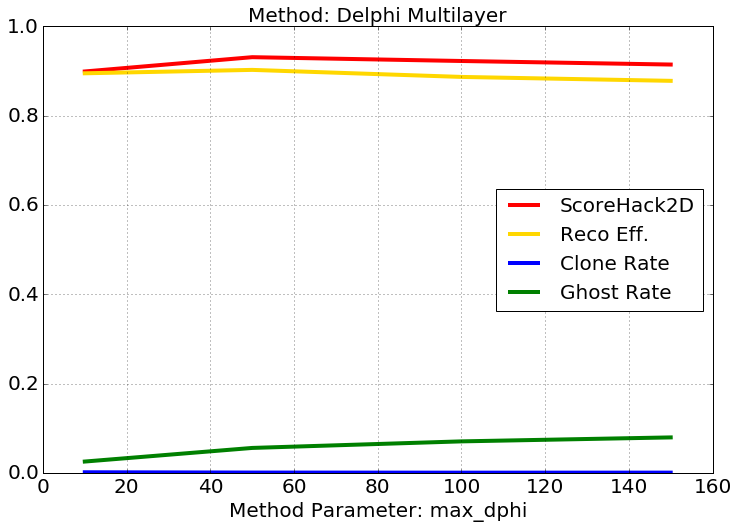

In [14]:
plt.figure(figsize=(12, 8))

plt.plot(X, score, label='ScoreHack2D', linewidth=4, color='r')
plt.plot(X, reco_eff, label='Reco Eff.', linewidth=4, color='gold')
plt.plot(X, clone_r, label='Clone Rate', linewidth=4, color='blue')
plt.plot(X, ghost_r, label='Ghost Rate', linewidth=4, color='green')

plt.title('Method: Delphi Multilayer', size=20)
plt.xlabel('Method Parameter: max_dphi', size=20)

plt.xticks(size=20)
plt.yticks(size=20)

plt.ylim(0, 1)

plt.legend(loc='best', prop={'size':20})
plt.grid(b=1)

plt.savefig('plots/delphi_'+name+'.png',format='png')
plt.show()